# Glucose Data Science
---
Goal: The goal of this experiment is to see if it is possible to predict which days I have exercised based on the days
blood glucose readings.
Stretch Goal: Predict the type of excercise.

### Technology:
- Apple HealthKit
- Dexcom Continuous Glucose Monitor
- Datascience
- Apple Watch Workouts

### High Level Objectives:
- Gather Data
- Inspect Data
- Data Wrangle
- Machine Learning with Data

### Background Information:
 I have __Type 1 Diabetes__ which is an auto-immune disease that causes my body to attack the insulin
 producing cells in my pancreas. Insulin is what helps your body use the energy (glucose) in the food you eat. To manage
 this disease I use some extremely cool pieces of technology. One is a continuous glucose monitor called a __Dexcom__
 CGM. I wear this cgm on my body, and it measures the amount of glucose in my interstitial fluid ( also known as the
 fluid between cells) every 5 minutes. That data is then sent to my phone ( even allowing me to view my real time
 glucose on my Apple Watch! ) as well as my insulin pump. This data, as well as other information is used to help manage
 my Diabetes.

 It has been my personal experience, that when I exercise, I tend to have higher insulin sensitivity, usually meaning
 better blood glucose numbers throughout the day. Your blood glucose is what your body automatically regulates on its
 own with insulin, but must be done manually as a type 1 diabetic.

 The goal of this exercise is to see if I can pull that correlation out with data, and possibly see if I can use a
 Machine Learning Model to predict which days I exercised, based only off my glucose data.

# Gather Data
---
The source of the exercise data will be Apple HealthKit. Apple HealthKit automatically has my exercise data in it from when I
track workouts on my Apple Watch. It also can be configured to sync with the Dexcom iOS app. So now lets see if we can download and load
that data.

## Export data from phone:
- Navigate to health app
- click on your profile icon
- scroll to bottom and click export all health data
- this may take a few minutes
- download zip
- expand zip
- this data is pretty sensitive, so don't commit it to git!


In [27]:
import sys
from os import path
print("The version of python is: ", sys.version)

The version of python is:  3.6.8 (v3.6.8:3c6b436a57, Dec 24 2018, 02:04:31) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


## Let's import this data into pandas
Note, we are also going to write the data we need to a csv cache to make it easier to work with. The reason being, theres
over 1GB of data!

In [28]:
import pandas as pd
input_path = './apple_health_export/export.xml'

# Don't do this conversion if we already created the csv cache
if not path.isfile('./csv_cache/glucose.csv'):
    import xmltodict
    with open(input_path, 'r') as xml_file:
        input_data = xmltodict.parse(xml_file.read())
    # available health records
    # thanks to this article for explaining:
    #   https://medium.com/better-programming/analyze-your-icloud-health-data-with-pandas-dd5e963e902f
    records_list = input_data['HealthData']['Record']
    workout_list = input_data['HealthData']['Workout']
    activity_list = input_data['HealthData']['ActivitySummary']
    # available odict_keys(['@locale', 'ExportDate', 'Me', 'Record', 'Workout', 'ActivitySummary'])

    df = pd.DataFrame(records_list)
    df.to_csv('./csv_cache/records.csv',header=True, index=False)

    df1 = pd.DataFrame(workout_list)
    df1.to_csv('./csv_cache/workout.csv',header=True, index=False)

    df2 = pd.DataFrame(activity_list)
    df2.to_csv('./csv_cache/activity.csv',header=True, index=False)

    # Data Wrangling cause this dataset is huuuuuuuge
    df3 = pd.DataFrame(records_list)
    # I only care about glucose values
    df3 = df3[df3["@type"] == 'HKQuantityTypeIdentifierBloodGlucose']
    # we only need the the below columns
    df3 = df3[['@sourceName', '@creationDate', '@value']]
    # This cuts the file from over a gig to 18 megs
    df3.to_csv('./csv_cache/glucose.csv',header=True, index=False)

    df = df3

else:
    glucose_df = pd.read_csv('./csv_cache/glucose.csv')
    workout_df = pd.read_csv('./csv_cache/workout.csv')

In [29]:
glucose_df.columns

Index(['@sourceName', '@creationDate', '@value'], dtype='object')

In [30]:
glucose_df.head()

,@sourceName,@creationDate,@value
0,Health,2014-10-15 23:09:19 -0800,167
1,Dexcom,2015-07-18 03:46:02 -0800,265
2,Dexcom,2015-07-18 03:51:02 -0800,246
3,Dexcom,2015-07-18 03:56:02 -0800,246
4,Dexcom,2015-07-18 04:01:02 -0800,233


## Healthkit Column Reference
These are the columns associated with the data we just pulled from HealthKit:

```python
# records
Index(['@type', '@sourceName', '@unit', '@creationDate', '@startDate',
       '@endDate', '@value', 'MetadataEntry', '@sourceVersion', '@device',
       'HeartRateVariabilityMetadataList'],
      dtype='object')
# workout
Index(['@workoutActivityType', '@duration', '@durationUnit', '@totalDistance',
       '@totalDistanceUnit', '@totalEnergyBurned', '@totalEnergyBurnedUnit',
       '@sourceName', '@sourceVersion', '@creationDate', '@startDate',
       '@endDate', 'MetadataEntry', 'WorkoutEvent', 'WorkoutRoute', '@device'],
      dtype='object')
# activity
Index(['@dateComponents', '@activeEnergyBurned', '@activeEnergyBurnedGoal',
       '@activeEnergyBurnedUnit', '@appleMoveTime', '@appleMoveTimeGoal',
       '@appleExerciseTime', '@appleExerciseTimeGoal', '@appleStandHours',
       '@appleStandHoursGoal'],
      dtype='object')
```

In [31]:
# Show All data types
glucose_df['@sourceName'].unique()

# show all source types
# df['@device'].unique()

# (Optional) Limit Data to phone
# df = df[df['@sourceName'].str.contains('iPhone')]

array(['Health', 'Dexcom', 'Dexcom G6'], dtype=object)

Keep in mind, workouts are stored in a different dataset that the main activity dataset.
I handle this in the above code by outputting them to seperate CSVs.

Also note if you want to see all data available in healthkit, take a peak at the apple docs.
[Apple Docs](https://developer.apple.com/documentation/healthkit/hkobjecttype)

In [32]:
# 474135 - 474305
last_day_bg = glucose_df[-200:]


<AxesSubplot:>

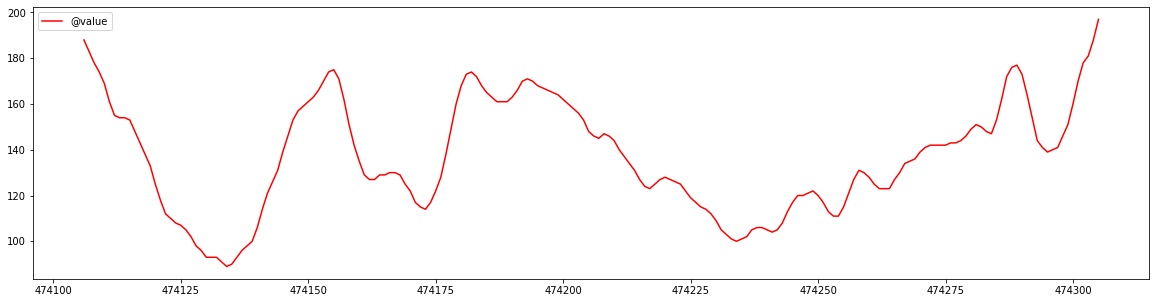

In [33]:
import matplotlib.pyplot as plt
last_day_bg.plot(kind='line',y='@value',color='red', figsize=(20,5))

Ok the range is looking right, and the graph is continuous which is a good sign.

# Data Wrangling

OK time for some more data wrangling. The goal is to feed a days worth of glucose values into a Neural Network,
and have the target be a binary 0,1 representing if I exercised that day or not.

![High Level Arch Diagram](https://dddiaz.com/post/glucose-sound/arch1.png)


To do that, I need to setup the input layer and output layer.
The input layer will be an array of arrays, with each day representing one array, and each array
representing a days worth of bucketed glucose values. (I will need to do some work to account for gaps)
The out array will just be an array of zeros and ones, with each value representing a day, and if I exercised on that day.


In [34]:
import numpy as np

# OK lets work with glucose values first
# First, how many values do we expect in one day, this will be the default array, assuming there is a reading every 5 mins.

default_number_of_readings_in_a_day = (24 * 60) / 5
# default_array = np.zeros(default_number_of_readings_in_a_day)

In [35]:
# lets convert datetime strings to actual datetime objects
glucose_df['@creationDate'] = pd.to_datetime(glucose_df['@creationDate'], format='%Y-%m-%d %H:%M:%S %z')


In [36]:
# next we need the first day we haev reading and the last day
last_glucose_date = glucose_df['@creationDate'].iloc[-1]
first_glucose_date = glucose_df['@creationDate'].iloc[0]
print(f"First day with data: {first_glucose_date}, Last day with data: {last_glucose_date}")

First day with data: 2014-10-15 23:09:19-08:00, Last day with data: 2021-01-31 14:10:46-08:00


In [37]:
from datetime import date

num_of_days = (last_glucose_date - first_glucose_date).days

print(num_of_days)

2299


In [48]:
# Ok now we want to iterate every day and start creating arrays of len 288
# Im sure there might be a way to do this with pandas timeseries, but im not quite sure how, for now i will loop, and bring shame upon myself ;p

import datetime
import numpy as np

# helper func
def padarray(arr):
    t = 288 - len(arr)
    if t > 0:
        return np.pad(arr, pad_width=(0, t), mode='constant')
    else:
        # TODO: uhoh we may need to resample in this case???
        return arr[:288]


# test helper func
def test_pdarray(x=[1,2,3]):
    res = padarray(x)
    assert len(res) == 288
    #print(res)
# test_pdarray()

In [50]:
# array of arrays of days of glucose values
glucose_X = []
# lets also keep track of days we got data for
glucose_X_days = []
day_to_search = first_glucose_date
for x in range(num_of_days):
    # Num of days is an upper bound, there could be multi day gaps with no glucose data, so we should check the next day exists in the data set
    # note we must use dt.dat here cause its a series
    day_data = glucose_df[(glucose_df['@creationDate'].dt.day == day_to_search.day) &
                          (glucose_df['@creationDate'].dt.month == day_to_search.month) &
                          (glucose_df['@creationDate'].dt.year == day_to_search.year)]
    # 2 represents the index where the glucose values exist
    day_data_glucose_array = day_data[['@value']].values

    if day_data_glucose_array.size == 0:
        # no values for this day
        # print(f"No values found for {day_to_search}")
        day_to_search += datetime.timedelta(days=1)
        continue

    day_data_glucose_array = np.concatenate( day_data_glucose_array, axis=0 )

    glucose_X_days.append(day_to_search)
    new_arr = padarray(day_data_glucose_array.flatten())
    glucose_X.append(new_arr)
    day_to_search += datetime.timedelta(days=1)

    # # Uncomment to test data
    # if len(glucose_X) > 5:
    #     break



In [51]:
# spot check a random day
# print(f"On day {glucose_X_days[2]} , these were my glucose values...")
# plt.plot(glucose_X[2])

In [52]:
# show all types of workouts we have done
workout_df['@workoutActivityType'].unique()

array(['HKWorkoutActivityTypeOther', 'HKWorkoutActivityTypeWalking',
       'HKWorkoutActivityTypeRunning', 'HKWorkoutActivityTypeCycling',
       'HKWorkoutActivityTypeHiking',
       'HKWorkoutActivityTypeStairClimbing',
       'HKWorkoutActivityTypeTraditionalStrengthTraining',
       'HKWorkoutActivityTypeSwimming', 'HKWorkoutActivityTypeYoga',
       'HKWorkoutActivityTypeSnowSports',
       'HKWorkoutActivityTypeFunctionalStrengthTraining',
       'HKWorkoutActivityTypeHighIntensityIntervalTraining',
       'HKWorkoutActivityTypeCooldown',
       'HKWorkoutActivityTypeCoreTraining'], dtype=object)

In [53]:
workout_df['@startDate'] = pd.to_datetime(workout_df['@startDate'], format='%Y-%m-%d %H:%M:%S %z')

In [54]:
# For each day we have glucose values, lets lookup and see if I exercised
workout_Y_days = []
for g_day in glucose_X_days:
    # Get all workouts on the day we are looking for
    workout_day_data = workout_df[(workout_df['@startDate'].dt.day == g_day.day) &
                                  (workout_df['@startDate'].dt.month == g_day.month) &
                                  (workout_df['@startDate'].dt.year == g_day.year)]
    # If a workout exists on this day, append a 1, else append a zero
    if len(workout_day_data) > 0:
        workout_Y_days.append(1)
        # print(f"Found workout on {g_day}")
    else:
        workout_Y_days.append(0)


In [55]:
print(f"I have tracked at least {workout_Y_days.count(1)} workouts on days I have glucose data.")

I have tracked at least 379 workouts on days I have glucose data.


### OK Checkpoint

I have my input array consisting of days of glucose values
I also have my output array of workouts for days on which i have glucose data.
Now for the machine learning part.

# Machine Learning With Glucose Data


In [56]:
import tensorflow as tf

In [57]:
# Set up train and test set
# training will be 80 percent of the values , and test will be 20
# chosen at random

day_len = len(glucose_X_days)

import random
import math
train_percent = .75

X_train_indexes = random.sample(range(day_len), math.floor(day_len * train_percent))
X_test_indexes = list(set(range(day_len)) - set(X_train_indexes))
Y_train_indexes = X_train_indexes
Y_test_indexes = X_test_indexes

In [58]:
X_train = []
X_test = []
Y_train = []
Y_test = []


In [59]:
for idx in X_train_indexes:
    X_train.append(glucose_X[idx])

for idx in X_test_indexes:
    X_test.append(glucose_X[idx])

for idx in Y_train_indexes:
    Y_train.append(workout_Y_days[idx])

for idx in Y_test_indexes:
    Y_test.append(workout_Y_days[idx])

In [60]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


What I will attempt to do here is treat a days worth of glucose values as an image almost.
Lets see what happens

In [62]:
model = Sequential()
# make sure input dim matches the number of glucose values
# https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
model.add(Dense(12, input_dim=288, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 12)                3468      
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 3,581
Trainable params: 3,581
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [66]:
# Convert the arrays to np arrays
X_train_np = np.array(X_train)
Y_train_np = np.array(Y_train)

X_test_np = np.array(X_test)
Y_test_np = np.array(Y_test)

In [69]:
model.fit(X_train_np, Y_train_np, epochs=150, batch_size=10, verbose=0)

In [70]:
# evaluate the keras model
_, accuracy = model.evaluate(X_test_np, Y_test_np)
print('Accuracy: %.2f' % (accuracy*100))

14/14 [==============================] - 0s 749us/step - loss: 0.4986 - accuracy: 0.7926
Accuracy: 79.26


# Results
Whoa! __79 Percent Accuracy__ based off my dataset!

In summary, that means the above Nueral Network can predict with 79 percent accuracy if I worked out on a particular day
based on that days glucose readings.

My initial response is that this a surprisingly high number! Going forward I want to examine techniques to ensure that
the model isn't over fitting for features I don't intend, but for a first pass, this seems like a great start. I also
want to explore techniques for improving my model as it is pretty rudimentary and how might I possibly predict workout type!


# Things to Consider/Improve for the future

- Sometimes vigourous excercise can effect glucose for several days, can we see that in the data
- Can we predict the Type of excercise in the future
- Should we be filtering on device, or any days in particular that have junk data
- Instead of workout_Y_array being binary, it could be a specific workout type, or the total number of workouts that day
- oh man, we could also potentially use total calories burned
- I also have general apple activity ring data, could be interesting to examine if my bg was better on days with closed
rings, or maybe days where i burned more than x calories

## TODO:
- replace data wrangling picture with one that is stored with the blog post and not in glucose-sound
- account for data gaps
- fine tune the model
- More Data.

## Issues:
- I only have 531 days of workouts


## Learnings:
- Data wrangling is important / hard
- Domain knowledge is critical to being able to gut check the data is looking right and behaving correctly

